# Dog-Breed Image Classification using AWS Sagemaker
This notebook walks through implementation of Image Classification Machine Learning Model to classify between 133 kinds of dog breeds using dog breed dataset provided by Udacity (https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip)

* We will be using a pretrained Resnet50 model from pytorch vision library( Concept of transfer Learning has been implemented)
* We will add an ouput of 133 neurons as there are 133 classes of dog breeds in the dataset
* Then we will perform Hyperparameter tuning by providing a range of values,to estimate the best values for the model
* Next we will be using the best hyperparameters and fine-tuning our Resent50 model.
* We will also be adding in configuration for Profiling and Debugging our training mode by adding in relevant hooks in the Training and Testing( Evaluation) phases.
* Next we will be deploying our model. While deploying we will create our custom inference script. The custom inference script will be overriding a few functions that will be used by our deployed endpoint for making inferences/predictions.
* Finally we will be testing out our model with some test images of dogs, to verfiy if the model is working as per our expectations.






In [ ]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [ ]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
from sagemaker.session import Session
from sagemaker import get_execution_role

role=get_execution_role()
sagemaker_session=sagemaker.Session()
region=sagemaker_session.boto_region_name
bucket=sagemaker_session.default_bucket()
print(f"region:{region}")
print(f"bucket:{bucket}")


region:us-east-1
bucket:sagemaker-us-east-1-647975508946


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [ ]:
#TODO: Fetch and upload the data to AWS S3
# Manually downloaded on local machine uncomment to download it via notebook
# Command to download and unzip data
# !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
# !unzip dogImages.zip

In [ ]:
prefix ="dogImagesDataset"
print("Starting to uploading dogImages")

inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)
print(f"Input path ( S3 file path ): {inputs}")

In [ ]:
#to avoid rerunning
inputs = 's3://sagemaker-us-east-1-647975508946/dogImagesDataset/'
print(f"Input path ( S3 file path ): {inputs}")

Input path ( S3 file path ): s3://sagemaker-us-east-1-647975508946/dogImagesDataset/


## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [ ]:
from sagemaker.tuner import(
CategoricalParameter,
ContinuousParameter,
HyperparameterTuner)

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.0001, 0.1),
    "eps": ContinuousParameter(1e-9, 1e-8),
    "weight_decay": ContinuousParameter(1e-3, 1e-1),
    "batch_size": CategoricalParameter([ 64, 128]),
}
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]


In [ ]:
from sagemaker.pytorch import PyTorch


estimator = PyTorch(
entry_point="hpo.py",
base_job_name="classification",
role=role,
instance_count=1,
instance_type = "ml.g4dn.xlarge",
py_version = "py36",
framework_version = "1.8"
)

tuner = HyperparameterTuner(
estimator,
objective_metric_name,
hyperparameter_ranges,
metric_definitions,
max_jobs=4,
max_parallel_jobs=2,
objective_type=objective_type, 
early_stopping_type="Auto"
)

In [ ]:

tuner.fit({"training":inputs},wait=True)

...........................................................................................................................................................................................................................................................................................!


In [ ]:


best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-01-17 07:40:59 Starting - Preparing the instances for training
2022-01-17 07:40:59 Downloading - Downloading input data
2022-01-17 07:40:59 Training - Training image download completed. Training in progress.
2022-01-17 07:40:59 Uploading - Uploading generated training model
2022-01-17 07:40:59 Completed - Training job completed


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"64"',
 'eps': '7.384494989553586e-09',
 'lr': '0.0027464603299771654',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"classification-2022-01-17-07-18-05-205"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-647975508946/classification-2022-01-17-07-18-05-205/source/sourcedir.tar.gz"',
 'weight_decay': '0.09605621750189348'}

In [ ]:
#printing out the best hyper-parameters
best_hyperparameters={'batch_size':int(best_estimator.hyperparameters()['batch_size'].replace('"',"")),
'eps':best_estimator.hyperparameters()['eps'],
'lr':best_estimator.hyperparameters()['lr'],
'weight_decay': best_estimator.hyperparameters()['weight_decay'],}
print(f"Best Hyperparamters after hyper-paramter fine tuning are: \n {best_hyperparameters}")

Best Hyperparamters after hyper-paramter fine tuning are: 
 {'batch_size': 64, 'eps': '7.384494989553586e-09', 'lr': '0.0027464603299771654', 'weight_decay': '0.09605621750189348'}


## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [ ]:
#  Set up debugging and profiling rules and hooks
from sagemaker.debugger import(
Rule,
rule_configs,
ProfilerRule,
DebuggerHookConfig,
# CollectionConfig,
ProfilerConfig,
FrameworkProfile)

rules=[
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]


profiler_config=ProfilerConfig(
system_monitor_interval_millis=500,framework_profile_params=FrameworkProfile(num_steps=10))

# collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
#     "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

# debugger_config=DebuggerHookConfig( collection_configs=collection_configs )
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)



In [ ]:
# TODO: Create and fit an estimator

estimator = PyTorch(
entry_point="train_model.py",
instance_count=1,
instance_type="ml.g4dn.xlarge",
role=role,
framework_version="1.6", #using 1.6 as it has support for smdebug lib , https://github.com/awslabs/sagemaker-debugger#debugger-supported-frameworks
py_version="py36",
hyperparameters=best_hyperparameters,
profiler_config=profiler_config, # include the profiler hook
debugger_hook_config=debugger_config, # include the debugger hook
rules=rules
)

estimator.fit({'train' : inputs },wait=True)

2022-01-17 07:43:14 Starting - Starting the training job...
2022-01-17 07:43:37 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2022-01-17 07:44:37 Starting - Preparing the instances for training.........
2022-01-17 07:45:57 Downloading - Downloading input data.........
2022-01-17 07:47:40 Training - Downloading the training image..
2022-01-17 07:47:58 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-17 07:47:56,469 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-01-17 07:47:56,489 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-01-17 07:47:59,553 sagemaker_pytorch_container.training INFO     Invoking user training scri

In [ ]:
#fetching jobname , client and description to be used for plotting.
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

print(f"Job name:{job_name}")
print(f"client:{client}")
print(f"description:{description}")

Job name:pytorch-training-2022-01-17-07-43-12-376
client:<botocore.client.SageMaker object at 0x7f55e8328bd0>
description:{'TrainingJobName': 'pytorch-training-2022-01-17-07-43-12-376', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:647975508946:training-job/pytorch-training-2022-01-17-07-43-12-376', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-647975508946/pytorch-training-2022-01-17-07-43-12-376/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'batch_size': '64', 'eps': '"7.384494989553586e-09"', 'lr': '"0.0027464603299771654"', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"pytorch-training-2022-01-17-07-43-12-376"', 'sagemaker_program': '"train_model.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-647975508946/pytorch-training-2022-01-17-07-43-12-376/source/sourcedir.tar.gz"', 'weight_decay': '"0.09605621750189348"'}, 'AlgorithmSpecificat

In [ ]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
trial = create_trial(estimator.latest_job_debugger_artifacts_path())


[2022-01-17 07:55:58.745 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-647975508946/pytorch-training-2022-01-17-07-43-12-376/debug-output


In [ ]:
trial.tensor_names()

[2022-01-17 07:56:02.447 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-01-17 07:56:03.470 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.bias',
 'gradient/ResNet_fc.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.relu_input_2',
 'layer3.4.relu_input_0',
 'layer3.4.relu_input_1',
 '

In [ ]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))


3

In [ ]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

3

In [ ]:
#Defining some utility functions to be used for plotting tensors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

#utility function to get data from tensors
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

#plot tensor utility functions for plotting tensors
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("Completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("Completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)
    plt.show()

loaded TRAIN data
loaded EVAL data
Completed TRAIN plot
Completed EVAL plot


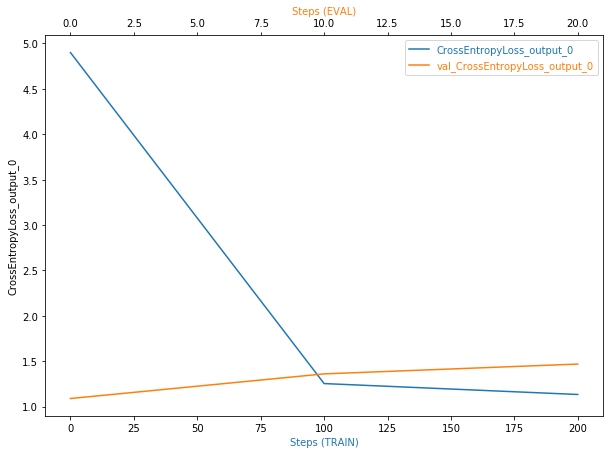

In [ ]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [ ]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"Profiler report location: {rule_output_path}")

Profiler report location: s3://sagemaker-us-east-1-647975508946/pytorch-training-2022-01-17-07-43-12-376/rule-output


In [ ]:
! aws s3 ls {rule_output_path} --recursive

2022-01-17 07:53:14     380993 pytorch-training-2022-01-17-07-43-12-376/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-01-17 07:53:14     230171 pytorch-training-2022-01-17-07-43-12-376/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-01-17 07:53:09        191 pytorch-training-2022-01-17-07-43-12-376/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-01-17 07:53:09      12132 pytorch-training-2022-01-17-07-43-12-376/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-01-17 07:53:09        126 pytorch-training-2022-01-17-07-43-12-376/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-01-17 07:53:09        129 pytorch-training-2022-01-17-07-43-12-376/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-01-17 07:53:09       3744 pytorch-training-2022-01-17-07-43-12-376/rule-output/ProfilerReport/profiler-output/profiler-re

In [ ]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-647975508946/pytorch-training-2022-01-17-07-43-12-376/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-647975508946/pytorch-training-2022-01-17-07-43-12-376/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-647975508946/pytorch-training-2022-01-17-07-43-12-376/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-647975508946/pytorch-training-2022-01-17-07-43-12-376/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-647975508946/pytorch-training-2022-01-17-07-4

In [ ]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [ ]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

In [ ]:
import shutil
shutil.make_archive("./profiler_repot.zip", "zip", "ProfilerReport")

'/root/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/profiler_repot.zip.zip'

## Model Deploying

In [ ]:
# Deploy your model to an endpoint -not reqd

# predictor=estimator.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge") 
#led to modelErrors

------!

In [ ]:
model_data = estimator.output_path + estimator.latest_training_job.job_name + "/output/model.tar.gz"
print(f"Model: {model_data}")

Model: s3://sagemaker-us-east-1-647975508946/pytorch-training-2022-01-17-07-43-12-376/output/model.tar.gz


In [ ]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

#If we need to override the serializer and deserializer then we need to pass them in an class inheriting the Predictor class and pass this class as parameter to our PyTorchModel
class ImgPredictor(Predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super( ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )
        
pytorch_model = PyTorchModel( model_data = model_data,
                            role = role,
                            entry_point= "inference.py",
                            py_version = "py36",
                            framework_version = "1.6",
                             predictor_cls = ImgPredictor
                            )

predictor = pytorch_model.deploy( initial_instance_count = 1, instance_type = "ml.t2.medium")

--------------!

Test image no: 1
Below is the image that we will be testing:


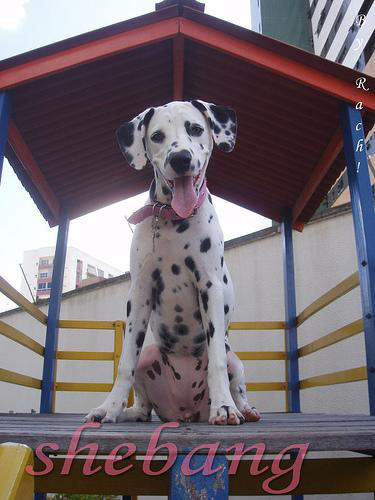

Expected dog breed category no : 129
Response: [[-13.21157455444336, -10.996954917907715, -6.828665733337402, -12.043157577514648, -13.947819709777832, -13.461549758911133, -8.489398956298828, -7.915266990661621, -11.392940521240234, -6.44766902923584, -7.468752861022949, -5.8688063621521, -13.249080657958984, -8.836019515991211, -12.308236122131348, -7.25164794921875, -14.682631492614746, -12.697261810302734, -3.2041568756103516, -11.933313369750977, -20.103187561035156, -19.914716720581055, -19.629093170166016, -11.887449264526367, -15.187424659729004, -18.28154945373535, -11.534204483032227, -8.426026344299316, -16.72873306274414, -9.763404846191406, -7.834994316101074, -15.434471130371094, -15.825387001037598, -8.907752990722656, -12.381791114807129, -15.07532024383545, -10.705211639404297, -11.361357688903809, -4.665918827056885, -11.889836311340332, -12.868621826171875, -13.064151763916016, -8.159366607666016, -14.590323448181152, -12.47630500793457, -11.576119422912598, -11.9828

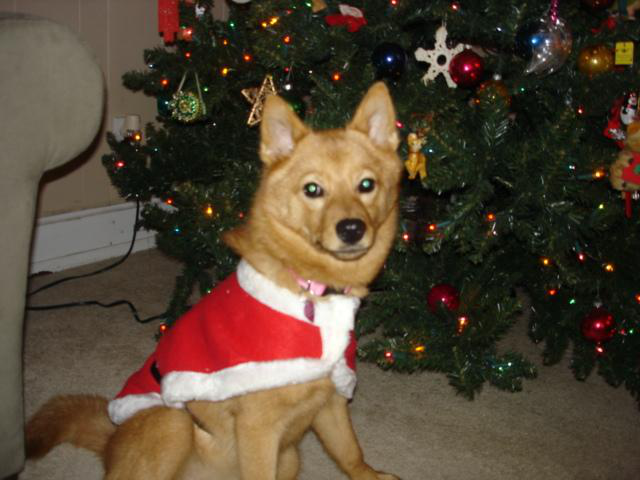

Expected dog breed category no : 5
Response: [[-11.644775390625, -15.041987419128418, -7.462072372436523, -1.0827338695526123, -9.285633087158203, -9.049142837524414, -7.884048938751221, -5.542206287384033, -12.007591247558594, -8.739373207092285, -2.3059585094451904, -8.88424301147461, -5.70707893371582, 0.802719235420227, -11.327609062194824, -3.516508102416992, -18.29935073852539, -11.864319801330566, -7.203882217407227, -5.954263210296631, -13.351364135742188, -13.524867057800293, -20.412857055664062, -9.011383056640625, -18.988582611083984, -15.821261405944824, -9.07170295715332, -10.759661674499512, -13.1340970993042, -7.497499465942383, -12.884740829467773, -12.136910438537598, -12.697184562683105, -10.793843269348145, -11.657832145690918, -14.02025318145752, -12.95107364654541, -9.998591423034668, -4.778285026550293, -11.939291954040527, -14.455662727355957, -9.170310974121094, -0.8759398460388184, -13.839173316955566, -3.50250244140625, -8.848594665527344, -7.326619625091553, 

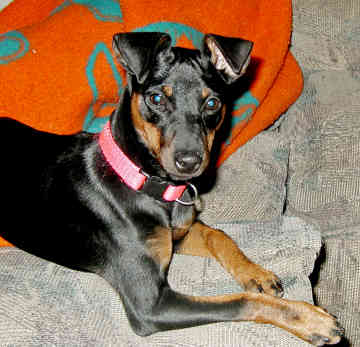

Expected dog breed category no : 21
Response: [[-10.252115249633789, -13.030280113220215, -3.943851947784424, -11.494253158569336, -13.113439559936523, -12.408870697021484, -5.74840784072876, -5.808749675750732, -12.937324523925781, -9.069214820861816, -4.456171035766602, -7.986161708831787, -9.68563175201416, -3.2412633895874023, -9.809306144714355, -7.345121383666992, -15.29436206817627, -3.9144606590270996, -8.595346450805664, -7.123201370239258, -14.873211860656738, -13.639579772949219, -17.011962890625, -11.077316284179688, -4.907536506652832, -14.945860862731934, -7.439528465270996, -3.8895344734191895, -12.946529388427734, -10.343790054321289, -11.25713062286377, -3.9838452339172363, -12.799588203430176, -2.030010461807251, -9.177483558654785, -13.897719383239746, -14.003486633300781, -8.224835395812988, -4.108822345733643, -10.900453567504883, -10.61508560180664, -13.764111518859863, -6.732905387878418, -10.236886024475098, -9.973050117492676, -10.086243629455566, -11.376137733

In [ ]:
from PIL import Image
import io
import os
import numpy as np

test_dir = "./testImages"
test_images = [ "TestImgDalmatian.jpg", 'TestImgFinnish_spitz.jpg', 'TestImgManchester_terrier.jpg' ]
test_images_expected_output = [129, 5, 21 ]
for index in range(len(test_images) ):
    test_img = test_images[index]
    expected_breed_category = test_images_expected_output[index]
    print(f"Test image no: {index+1}")
    test_file_path = os.path.join(test_dir,test_img)
    with open(test_file_path , "rb") as f:
        payload = f.read()
        print("Below is the image that we will be testing:")
        display(Image.open(io.BytesIO(payload)))
        print(f"Expected dog breed category no : {expected_breed_category}")
        response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
        print(f"Response: {response}")
        predicted_dog_breed = np.argmax(response,1) + 1 #We need to do plus 1 as index starts from zero and prediction is zero-indexed
        print(f"Response/Inference for the above image is : {predicted_dog_breed}")

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
#deleted manually
predictor.delete_endpoint()